<a href="https://colab.research.google.com/github/diaputr/machine-learning/blob/main/Modul_10_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum 1: RNN untuk Analisis Sentimen

## Setup


In [4]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [5]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline

In [6]:
dataset, info = tfds.load('imdb_reviews', with_info=True,as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [7]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'James J. Corbett\'s autobiography "The Roar of the Crowd" was the starting point of this lively and well-remembered fictionalized biography. The author was heavyweight champion of the world, succeeding John L. Sullivan, before the turn of the century. The events of the narrative depict Corbett as a brash but likable and intelligent young man whose conquest of the world of boxing and social prejudice in his time, when he was considered merely the son of Irish immigrants, a lowly bank teller and a nobody surprised everyone. It took him several hours of exciting and often amusing screen-time to prove his compeers were wrong. He is an bank teller when the film opens, but he somehow wangles an invitation to a sporting club for the well-to-do. He falls in love with a beautiful but snobbish girl, with whom he always seems to be quarreling, and he lives at home with a brawling clan of Corbetts who seem to fight with one another as often as with others. When he defeats the club\'s be

## Buat Teks Encoder

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[565,   1,   1, ...,   0,   0,   0],
       [ 42, 627,  21, ...,   0,   0,   0],
       [  1,   1,   7, ...,   0,   0,   0]])

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'James J. Corbett\'s autobiography "The Roar of the Crowd" was the starting point of this lively and well-remembered fictionalized biography. The author was heavyweight champion of the world, succeeding John L. Sullivan, before the turn of the century. The events of the narrative depict Corbett as a brash but likable and intelligent young man whose conquest of the world of boxing and social prejudice in his time, when he was considered merely the son of Irish immigrants, a lowly bank teller and a nobody surprised everyone. It took him several hours of exciting and often amusing screen-time to prove his compeers were wrong. He is an bank teller when the film opens, but he somehow wangles an invitation to a sporting club for the well-to-do. He falls in love with a beautiful but snobbish girl, with whom he always seems to be quarreling, and he lives at home with a brawling clan of Corbetts who seem to fight with one another as often as with others. When he defeats the club\'s 

## Buat Model

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.01287158]


In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 60ms/step
[0.01287158]


In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train Model

In [18]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 51s 102ms/step - loss: 0.6273 - accuracy: 0.5812 - val_loss: 0.4618 - val_accuracy: 0.7979
Epoch 2/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3849 - accuracy: 0.8258 - val_loss: 0.3621 - val_accuracy: 0.8427
Epoch 3/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3346 - accuracy: 0.8544 - val_loss: 0.3398 - val_accuracy: 0.8500
Epoch 4/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3218 - accuracy: 0.8606 - val_loss: 0.3357 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3142 - accuracy: 0.8634 - val_loss: 0.3277 - val_accuracy: 0.8484
Epoch 6/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3065 - accuracy: 0.8680 - val_loss: 0.3204 - val_accuracy: 0.8589
Epoch 7/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3045 - accuracy: 0.8697 - val_loss: 0.3381 - val_accuracy

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 29ms/step - loss: 0.3174 - accuracy: 0.8588
Test Loss: 0.31738415360450745
Test Accuracy: 0.8588399887084961


(0.0, 0.6436117991805077)

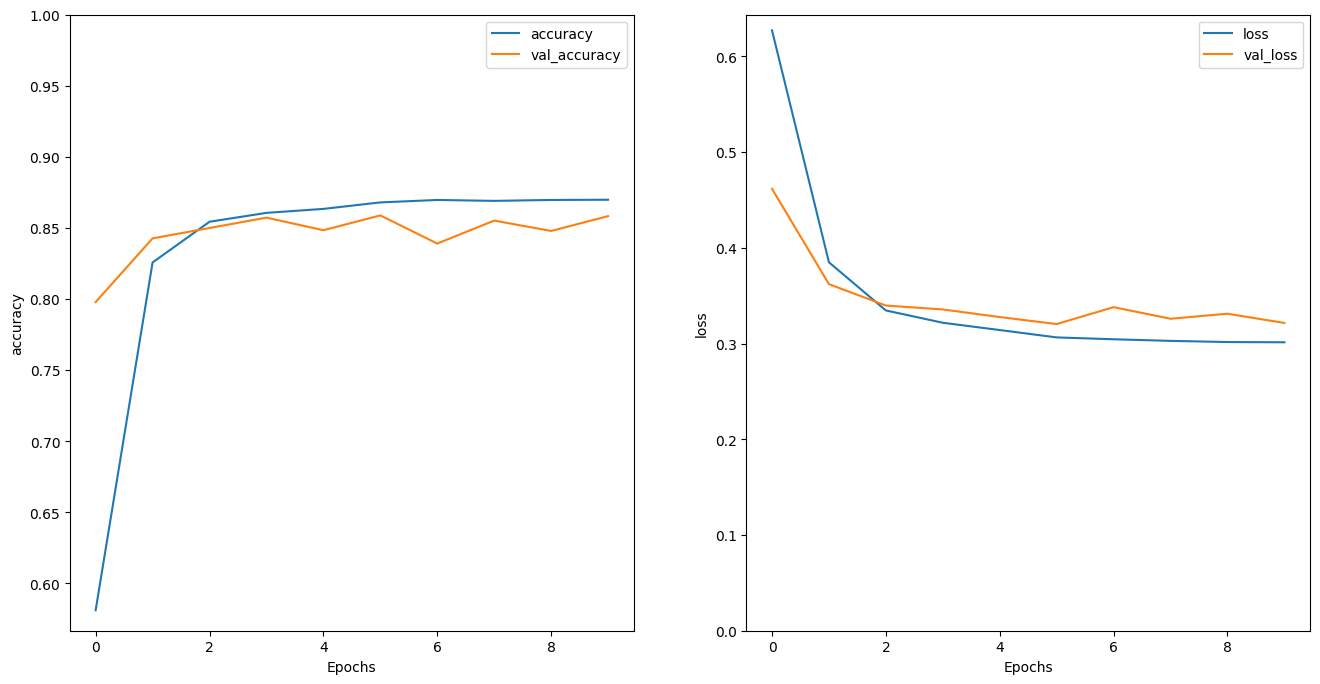

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


## Stack two or more LSTM layers

In [22]:
model = tf.keras.Sequential([encoder, tf.keras.layers.Embedding(
  len(encoder.get_vocabulary()), 64, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 75s 147ms/step - loss: 0.6056 - accuracy: 0.6100 - val_loss: 0.4152 - val_accuracy: 0.8120
Epoch 2/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3828 - accuracy: 0.8358 - val_loss: 0.3624 - val_accuracy: 0.8531
Epoch 3/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3383 - accuracy: 0.8570 - val_loss: 0.3459 - val_accuracy: 0.8552
Epoch 4/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3199 - accuracy: 0.8646 - val_loss: 0.3252 - val_accuracy: 0.8505
Epoch 5/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3183 - accuracy: 0.8642 - val_loss: 0.3406 - val_accuracy: 0.8479
Epoch 6/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3124 - accuracy: 0.8698 - val_loss: 0.3278 - val_accuracy: 0.8427
Epoch 7/10
391/391 [==============================] - 45s 116ms/step - loss: 0.3066 - accuracy: 0.8717 - val_loss: 0.3223 - val_ac

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 50ms/step - loss: 0.3170 - accuracy: 0.8641
Test Loss: 0.31699100136756897
Test Accuracy: 0.8641200065612793


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-2.100069]]


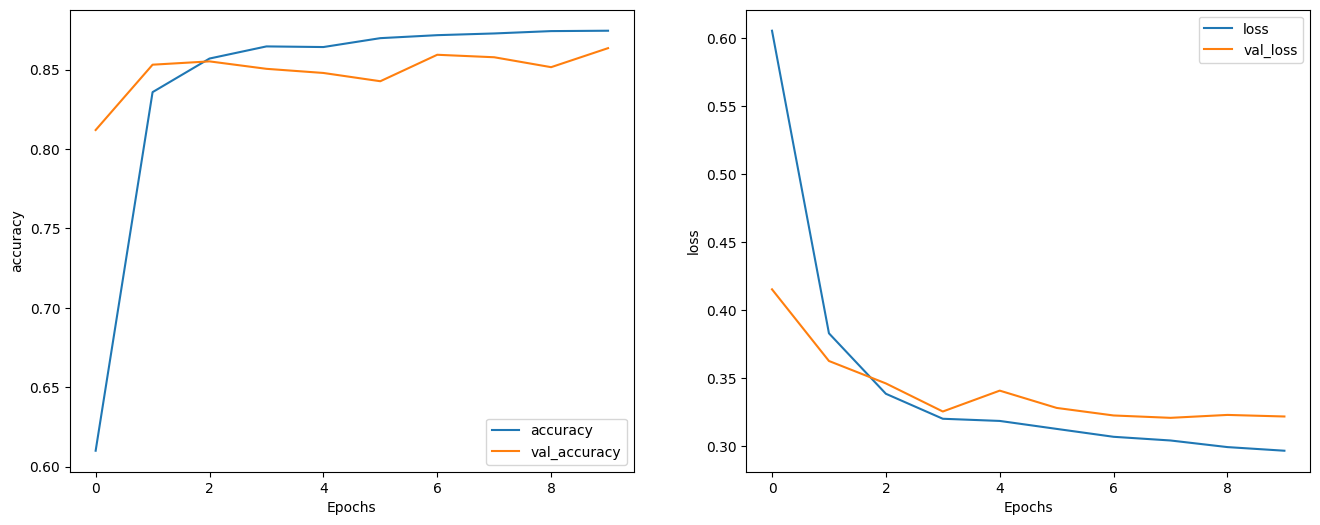

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Praktikum 2: Generator Teks dengan RNN

## Import TensorFlow

In [28]:
import tensorflow as tf
import numpy as np
import os
import time

## Download Dataset Shakespeare

In [29]:
path_to_file  = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 1s 1us/step


## Load Data

In [30]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [31]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [32]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## Vectorize Teks

In [33]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [34]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

In [35]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [36]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [37]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [38]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [39]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

## Membuat Trianing Set dan Target

In [40]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [41]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [42]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [43]:
seq_length = 100

In [44]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [45]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [46]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [47]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [48]:
dataset = sequences.map(split_input_target)

In [49]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


## Membuat Batch Training

In [50]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Buat Model

In [51]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [52]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [53]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## Uji Model

In [54]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [55]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [57]:
sampled_indices

array([36, 45,  2, 12, 43, 42, 12,  7, 37, 38, 16, 37, 12, 20, 50, 55, 27,
       59, 60, 61, 57, 39, 42, 31, 15, 23,  0, 54, 38, 56,  9, 17, 42, 34,
       61, 13, 62, 28,  0, 59, 51, 64, 41,  6, 54, 47, 12, 50, 35, 33, 24,
       60, 10, 54, 17, 33, 47, 37,  0, 12, 47, 53,  8,  1, 58, 61, 13, 63,
       17, 55, 31, 17, 55, 13, 20,  3,  9, 56, 34, 21, 17, 49, 19, 24, 34,
       37, 51, 65, 63, 56, 13, 61, 12, 64, 44, 14, 22, 36, 20, 22])

In [58]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b' III:\nHe was in the right; and so indeed it is.\nTen the clock there. Give me a calendar.\nWho saw the'

Next Char Predictions:
 b"Wf ;dc;,XYCX;GkpNtuvrZcRBJ[UNK]oYq.DcUv?wO[UNK]tlyb'oh;kVTKu3oDThX[UNK];hn-\nsv?xDpRDp?G!.qUHDjFKUXlzxq?v;yeAIWGI"


## Tambahan optimizer dan fungsi loss

In [59]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [60]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1913624, shape=(), dtype=float32)


In [61]:
tf.exp(example_batch_mean_loss).numpy()

66.1128

In [62]:
model.compile(optimizer='adam', loss=loss)

## Konfigurasi Checkpoints

In [63]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

## Lakukan Proses Training

In [64]:
EPOCHS = 20

In [65]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 14s 59ms/step - loss: 2.7069
Epoch 2/20
172/172 [==============================] - 12s 58ms/step - loss: 1.9776
Epoch 3/20
172/172 [==============================] - 11s 58ms/step - loss: 1.6967
Epoch 4/20
172/172 [==============================] - 11s 57ms/step - loss: 1.5390
Epoch 5/20
172/172 [==============================] - 11s 56ms/step - loss: 1.4425
Epoch 6/20
172/172 [==============================] - 12s 56ms/step - loss: 1.3754
Epoch 7/20
172/172 [==============================] - 11s 56ms/step - loss: 1.3238
Epoch 8/20
172/172 [==============================] - 11s 57ms/step - loss: 1.2796
Epoch 9/20
172/172 [==============================] - 11s 58ms/step - loss: 1.2386
Epoch 10/20
172/172 [==============================] - 12s 58ms/step - loss: 1.1982
Epoch 11/20
172/172 [==============================] - 12s 56ms/step - loss: 1.1583
Epoch 12/20
172/172 [==============================] - 11s 57ms/step - loss: 1.1166
E

## Generate Teks

In [66]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [67]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [68]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
How but well say?

LUCENTIO:
Lech our own proceeding trees, and lively will,
Cursessing to hell have softer bear. If could not stay unto
quancilike thou my services.

Citizens:
Now suffer's, my lord.

KING RICHARD III:
Say, you will discontent it was too hither brought
A model of the impose: he that lies in thee,
Displacued the step; for one poor bark with welcome!

DUKE VINCENTIO:
That he would not, knowing what you shall swear;
Where I shall accuse this gentleman and swoonest,
Your father thereof makes one foot Criffoft. Sprigate,
To make the fire of what yield to her herses?

Second Murderer:
Let him fool; there is strange for Claudio's duty!

LUCENTIO:
And women are so annight, like confession well.
Hollat! I did remain.

DUKE VINCENTIO:
Fiend sir, sir, he'll be delicer'd, by some another
After of Bohemia's and the lany was false
Slain awhile. You have painted laugh aimnon of mine
Or invereforated had dropp'd my body to sockaribal;
That is, she bid me speak with him!--
With 

In [69]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nGood morrow to their scratch! O dishonest wretch!\nWhat God you think, sir?\n\nLUCIO:\nThat's likewise possible; on the orator,\nIf you will his my body shall she, my liege,\nMy left her gown, sir, being on't ask: but, sir,\nwhen he gives our batters; and sit passing exilith:\nHenry of a better but a foot\nCaius Marcius, though nothing light repose his helm:\nNisteed post, will go with telling where he wounded;\nForced by this it is too great and horses,\nCell-courteous the queen's blows.\n\nPERDITA:\nO, I your duty!\nO, then, I dread not more than these two ather.\nABrayland, for thy liping steel about him,\nNor mortal to Domb Enchanother.\n\nClown:\nSo pace of hers, consider little as\nin hand that wouldst die for this fellow?\nMean till my sword we pait: let that place.\n\nPAULINA:\nCall forth that cushions, I\nWart through the hand of that word 'tis.\n\nLUCENTIO:\nBut is it not so.\n\nISABELLA:\nUngued'st him from fifte your boy? nay, come, sir.\n\nYORK:\nSo m

## Ekspor Model Generator

In [70]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [71]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
The yarnible of poor Clarence dedy thy
studies, sepious, these graces brothers.

Second Citizen:
Ba


# Tugas

Prosedur pelatihan pada praktikum 2 merupakan prosedur sederhana, yang tidak memberi kita banyak kendali. Model ini menggunakan "teacher-forcing" yang mencegah prediksi buruk diumpankan kembali ke model, sehingga model tidak pernah belajar untuk pulih dari kesalahan.

Jadi, setelah kita melihat cara menjalankan model secara manual, selanjutnya kita akan mengimplementasikan custom loop pelatihan. Hal ini memberikan titik awal jika, misalnya, kita ingin menerapkan pembelajaran kurikulum untuk membantu menstabilkan keluaran open-loop model. Bagian terpenting dari loop pelatihan khusus adalah fungsi langkah pelatihan.

Gunakan `tf.GradientTape` untuk men track nilai gradient. Kita dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca [eager execution guide](https://www.tensorflow.org/guide/eager).
Prosedurnya adalah:
1. Jalankan Model dan hitung loss dengan `tf.GradientTape`.
2. Hitung update dan terapkan pada model dengan optimizer.

In [72]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
      predictions = self(inputs, training=True)
      loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

Kode diatas menerapkan train_step method sesuai dengan  [Keras' train_step conventions](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit). Ini opsional, tetapi memungkinkan kita mengubah perilaku langkah pelatihan dan tetap menggunakan keras [Model.compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) and [Model.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) methods.

In [73]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [74]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [75]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 15s 57ms/step - loss: 2.6981


Atau jika ingin lebih mengetahui dalamnya, kita bisa membuat custom training loop sendiri:

In [78]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
  start = time.time()
  mean.reset_states()

  for (batch_n, (inp, target)) in enumerate(dataset):
    logs = model.train_step([inp, target])
    mean.update_state(logs['loss'])

    if batch_n % 50 == 0:
      template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
      print(template)

  # saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    model.save_weights(checkpoint_prefix.format(epoch=epoch))
  print()
  print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
  print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
  print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 1.1529
Epoch 1 Batch 50 Loss 1.1841
Epoch 1 Batch 100 Loss 1.1944
Epoch 1 Batch 150 Loss 1.2234

Epoch 1 Loss: 1.1968
Time taken for 1 epoch 10.97 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.1565
Epoch 2 Batch 50 Loss 1.1482
Epoch 2 Batch 100 Loss 1.1380
Epoch 2 Batch 150 Loss 1.1513

Epoch 2 Loss: 1.1569
Time taken for 1 epoch 11.65 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.0986
Epoch 3 Batch 50 Loss 1.0947
Epoch 3 Batch 100 Loss 1.1500
Epoch 3 Batch 150 Loss 1.1225

Epoch 3 Loss: 1.1146
Time taken for 1 epoch 11.61 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.0377
Epoch 4 Batch 50 Loss 1.0859
Epoch 4 Batch 100 Loss 1.0651
Epoch 4 Batch 150 Loss 1.0571

Epoch 4 Loss: 1.0716
Time taken for 1 epoch 11.10 sec
_____________________________________________________________________

Jalankan kode di atas dan sebutkan perbedaanya dengan praktikum 2?